## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation,Flatten
from keras.layers import LeakyReLU
from tensorflow.keras import regularizers
import sys
import h5py
import glob

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras_video import VideoFrameGenerator

In [4]:
classes = [i.split(os.path.sep)[4] for i in glob.glob('D:\\Thesis Works\\Datasets\\RLVD\\*')]
print(classes)
classes.sort()
# some global params
SIZE = (144, 144)
CHANNELS = 3
NBFRAME = 25
BS = 8
# pattern to get videos and classes
glob_pattern='D:\\Thesis Works\\Datasets\\RLVD\\{classname}\\*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=0.20,
    split_test=0.1,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=True)

['NonViolence', 'Violence']
class NonViolence, validation count: 200, test count: 80, train count: 720
class Violence, validation count: 200, test count: 80, train count: 720
Total data: 2 classes for 1440 files for train


In [5]:
valid = train.get_validation_generator()

Total data: 2 classes for 400 files for validation


In [6]:
test = train.get_test_generator()

Total data: 2 classes for 160 files for test


In [7]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPooling2D, GlobalMaxPool2D,GlobalAveragePooling2D, AveragePooling2D, Conv3D, LSTM, Bidirectional,\
    MaxPooling3D, GlobalMaxPool3D, Reshape, ConvLSTM2D

from keras.layers import TimeDistributed, GRU, Dense, Dropout
def main_model():
    momentum = .9
    model = Sequential()
   
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (25, 144, 144, 3)))
    model.add(BatchNormalization(momentum = momentum))
    model.add(TimeDistributed(MaxPooling2D((4, 4), padding='same'))) 

   
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(BatchNormalization(momentum = momentum))
    model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(BatchNormalization(momentum = momentum))
    model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
    
    model.add(TimeDistributed(Conv2D(512, (3, 3), padding='same',activation = 'relu')))
    model.add(BatchNormalization(momentum = momentum))
    model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))



    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(512,return_sequences = True)))
    model.add(Bidirectional(LSTM(128,return_sequences = True)))
    model.add(Bidirectional(LSTM(64)))
    
    model.add(Dense(256, activation="relu"))

    model.add(Dense(2, activation = 'softmax'))

    ########################################################################################################################

    
    # Return the constructed convlstm model.
    return model

In [8]:
model = main_model()
optimizer = tf.optimizers.Adam(0.0001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['accuracy']
)


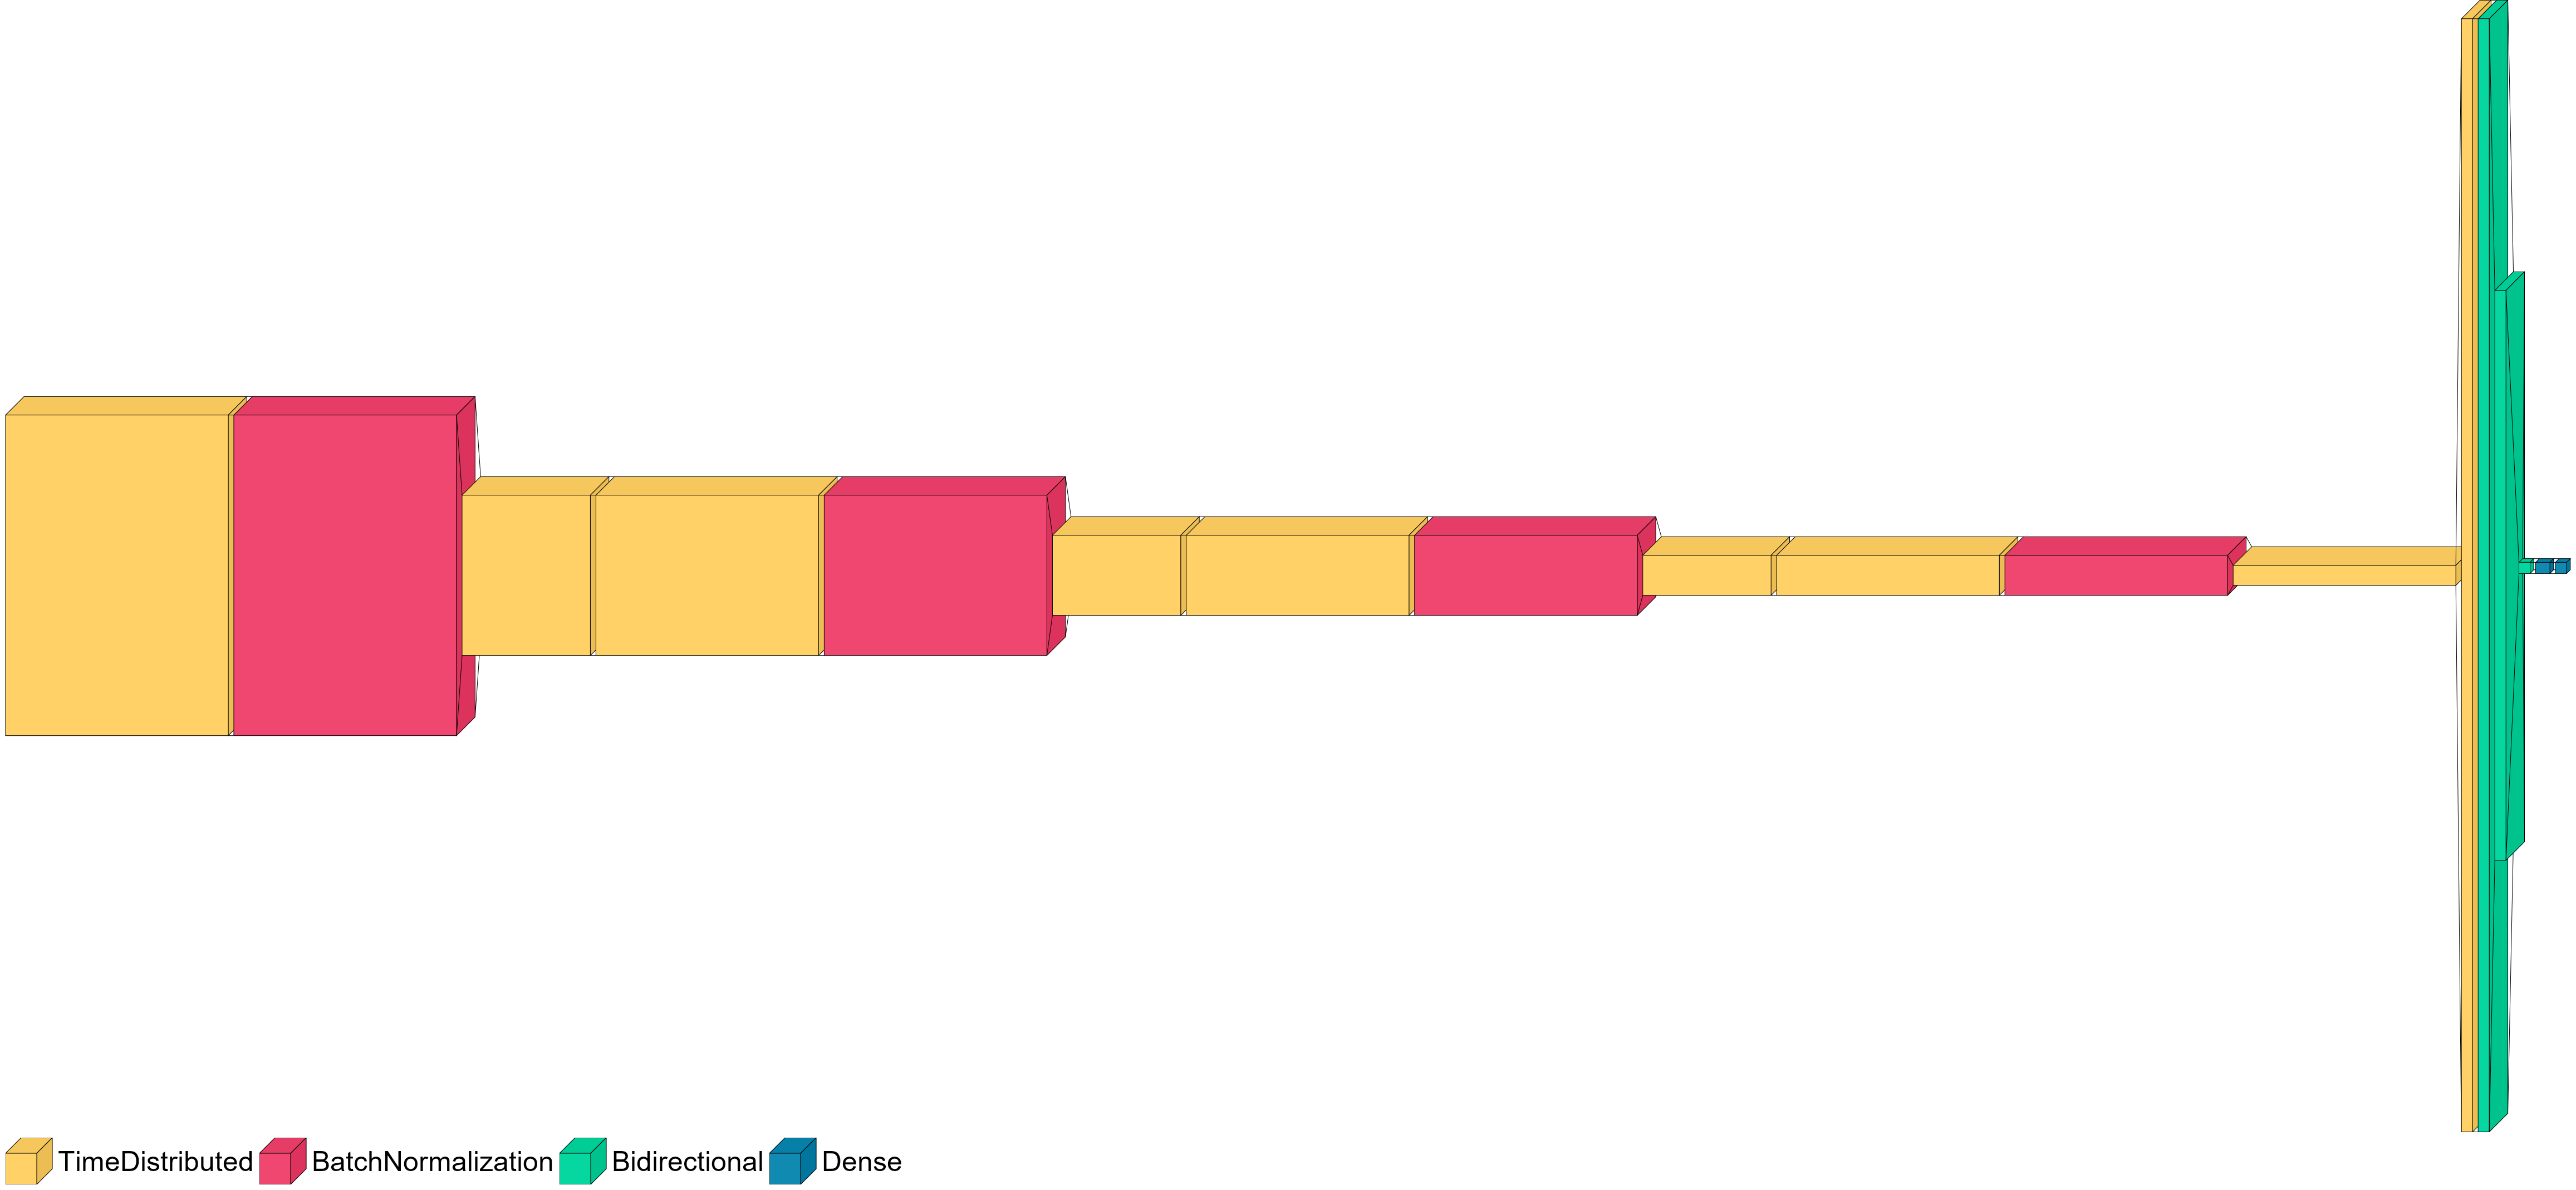

In [29]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf",50)
visualkeras.layered_view(model,legend=True,font=font)

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 25, 144, 144, 32)  896      
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 25, 144, 144, 32)  128      
 hNormalization)                                                 
                                                                 
 time_distributed_10 (TimeDi  (None, 25, 36, 36, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 25, 36, 36, 64)   18496     
 stributed)                                                      
                                                                 
 batch_normalization_5 (Batc  (None, 25, 36, 36, 64)  

In [10]:
EPOCHS=60

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor ='val_loss',factor = 0.1,min_delta=0.02,patience = 5,verbose=1,min_lr=0.0000000001),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.02,
        patience=15,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )
    
]
history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

# model.save('my_mode3.h5')

Epoch 1/60
180/180 [==============================] - 321s 2s/step - loss: 0.5592 - accuracy: 0.6986 - val_loss: 0.4286 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 2/60
180/180 [==============================] - 22s 122ms/step - loss: 0.3747 - accuracy: 0.8201 - val_loss: 0.2925 - val_accuracy: 0.8825 - lr: 1.0000e-04
Epoch 3/60
180/180 [==============================] - 22s 120ms/step - loss: 0.2751 - accuracy: 0.8826 - val_loss: 0.2615 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/60
180/180 [==============================] - 22s 124ms/step - loss: 0.1995 - accuracy: 0.9167 - val_loss: 0.2729 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 5/60
180/180 [==============================] - 22s 123ms/step - loss: 0.1502 - accuracy: 0.9451 - val_loss: 0.2314 - val_accuracy: 0.9050 - lr: 1.0000e-04
Epoch 6/60
180/180 [==============================] - 22s 123ms/step - loss: 0.1362 - accuracy: 0.9465 - val_loss: 0.2493 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 7/60
180/180 [==========

In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [9]:
loaded_model = tf.keras.models.load_model('my_model1.h5')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


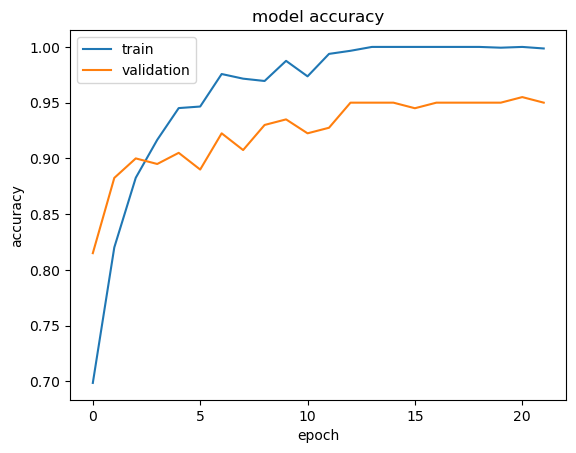

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


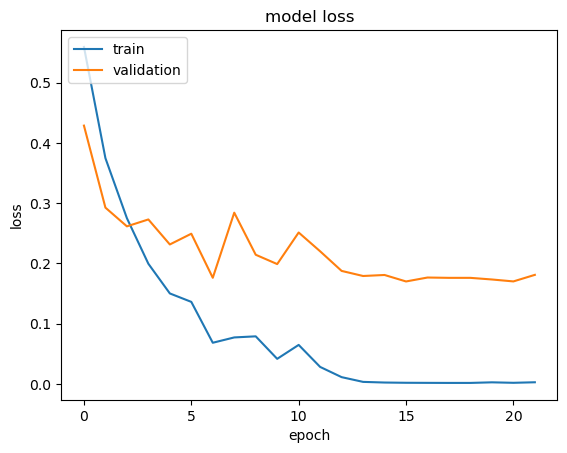

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [13]:
# load_model.load_weights('checkpoint/')

result = model.evaluate(test)

20/20 [==============================] - 1s 54ms/step - loss: 0.2165 - accuracy: 0.9438


In [18]:
print(test[0])

(array([[[[[0.25490198, 0.16862746, 0.30588236],
          [0.15686275, 0.05490196, 0.17254902],
          [0.20392159, 0.09803922, 0.14509805],
          ...,
          [0.11764707, 0.05882353, 0.09019608],
          [0.14901961, 0.05882353, 0.10196079],
          [0.16470589, 0.06666667, 0.1137255 ]],

         [[0.26666668, 0.19215688, 0.3254902 ],
          [0.14117648, 0.03921569, 0.15686275],
          [0.20392159, 0.09803922, 0.14509805],
          ...,
          [0.03529412, 0.        , 0.01960784],
          [0.02352941, 0.        , 0.00784314],
          [0.03137255, 0.        , 0.01176471]],

         [[0.3019608 , 0.227451  , 0.36078432],
          [0.12941177, 0.02745098, 0.14509805],
          [0.19215688, 0.09803922, 0.13333334],
          ...,
          [0.00392157, 0.        , 0.00784314],
          [0.        , 0.        , 0.00392157],
          [0.        , 0.        , 0.01176471]],

         ...,

         [[0.48627454, 0.2509804 , 0.25882354],
          [0.4901961 

In [11]:
x_test = []
for x in range(test.__len__()):
    #position [0] for data
    batch = test.__getitem__(x)[0]
    for y in range(BS):
        x_test.append(batch[y])
#Get labels indices
# x_test = np.argmax(y_test, axis=1)

In [20]:
x_test=np.array(x_test)

x_test1 = np.reshape(x_test, (x_test.shape[0]*x_test.shape[1],) + x_test.shape[2:])

batch1 = test.__getitem__(x)[0]



print(x_test1.shape)
print(x_test.shape)
print(batch1.shape)

(5120, 112, 112, 3)
(256, 20, 112, 112, 3)
(8, 20, 112, 112, 3)


In [25]:
y_test = []
for x in range(test.__len__()):
    #position [1] for labels
    batch = test.__getitem__(x)[1]
    for y in range(BS):
        y_test.append(batch[y])
#Get labels indices
y_test = np.argmax(y_test, axis=1)

In [21]:
x_test = []     # store all the generated data batches
y_test = []   # store all the generated label batches
max_iter = 100  # maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
i = 0
for x, y in test:
    x_test.append(x)
    y_test.append(y)
    break
    i += 1
    if i == max_iter:
        break

In [26]:
x_test = np.array(x_test)



y_test = np.array(y_test)

y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1],) + y_test.shape[2:])

In [27]:
x_test = np.reshape(x_test, (x_test.shape[0]*x_test.shape[1],) + x_test.shape[2:])
#print(x_test)
x_test.shape

(8, 20, 112, 112, 3)

In [21]:
predictions = loaded_model.predict(batch1)
preds = predictions > 0.5

In [22]:
batchY = test.__getitem__(x)[1]
batchY.shape

(8, 2)

In [26]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(batchY, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

ValueError: multilabel-indicator is not supported